In [ ]:
#--- Imports ---#

import torch as pt
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import deepxde as dde
import numpy as np
from deepxde.backend import torch   # switch to torch if needed

#import json
#import pandas as pd
#from math import pi
#from numpy.linalg import svd, lstsq, cond
#import scipy.linalg as la
#import scipy



In [ ]:
#==== MLPs ====#

"""
███████╗ ██╗   ██╗ █████╗ ██╗      ███╗   ██╗███████╗████████╗███████╗
██╔═══██╗██║   ██║██╔══██╗██║      ████╗  ██║██╔════╝╚══██╔══╝██╔════╝
██║   ██║██║   ██║███████║██║      ██╔██╗ ██║█████╗     ██║   ███████╗
██║   ██║██║   ██║██╔══██║██║      ██║╚██╗██║██╔══╝     ██║   ╚════██║
███████╔╝╚██████╔╝██║  ██║███████╗ ██║ ╚████║███████╗   ██║   ███████║
 ╚═════╝  ╚═════╝ ╚═╝  ╚═╝╚══════╝ ╚═╝  ╚═══╝╚══════╝   ╚═╝   ╚══════╝
"""


class Sin(nn.Module):
    def forward(self, input):
        return pt.sin(input)


class SimpleMLP(nn.Module):
    """
    Feedforward MLP for the solution surface u(t, x[, y, ...]).
    input_size should equal 1 + spatial_dim. We accept variable coords in forward()
    and concatenate them (t, x[, y, ...]) along dim=1.
    """
    def __init__(self, n_layers, hidden_size, input_size=2):
        super(SimpleMLP, self).__init__()
        assert n_layers >= 2, "n_layers must be at least 2"

        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())

        for _ in range(n_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, *coords):
        # coords expected as (t, x) or (t, x, y, ...)
        input_tensor = pt.cat(coords, dim=1)
        return self.model(input_tensor)


class symMLP(nn.Module):
    """
    Operator network v(F). For interpretable discovery set n_layers=1 (pure linear).
    """
    def __init__(self, input_size, n_layers, hidden_size=0, linear_only=False):
        super(symMLP, self).__init__()
        assert n_layers >= 1, "n_layers must be at least 1"

        layers = []
        if n_layers == 1:
            layers.append(nn.Linear(input_size, 1, bias=True))
        else:
            layers.append(nn.Linear(input_size, hidden_size))
            if not linear_only:
                layers.append(nn.ReLU())
            for _ in range(n_layers - 2):
                layers.append(nn.Linear(hidden_size, hidden_size))
                if not linear_only:
                    layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_size, 1))

        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        if x is None: 
            print("symMLP: x is None")
        return self.model(x)



In [ ]:
# === Trainer ===
"""
████████╗██████╗  █████╗ ██╗███╗   ██╗███████╗██████╗
╚══██╔══╝██╔══██╗██╔══██╗██║████╗  ██║██╔════╝██╔══██╗
   ██║   ██████╔╝███████║██║██╔██╗ ██║█████╗  ██████╔╝
   ██║   ██╔══██╗██╔══██║██║██║╚██╗██║██╔══╝  ██╔══██╗
   ██║   ██║  ██║██║  ██║██║██║ ╚████║███████╗██║  ██║
   ╚═╝   ╚═╝  ╚═╝╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝╚══════╝╚═╝  ╚═╝
"""

class PDETrainer:
    """
    Trains u(t, x[, y]) and v(F) jointly or alternately.
    - selected_derivs: iterable of feature names ('u_x','u_xx','u_y','u_yy','uu','u_x_xx','uu_x', ...)
    Scaling convention:
      u_x -> u_x / a, u_xx -> u_xx / a^2, u_t compared as u_t / a^2
      Composite powers are summed (e.g., u_x_xx has power 3).
    """
    def __init__(self, u_config, v_config, lr=1e-3, lambda_reg=1e-3, lambda_a=1e-3, selected_derivs=(), dim=1):
        self.u = SimpleMLP(**u_config)
        self.v = symMLP(**v_config)
        self.log_a = nn.Parameter(pt.zeros(1))
        self.lambda_reg = lambda_reg
        self.lambda_a   = lambda_a
        self.selected_derivs = list(selected_derivs)  # freeze order
        self.dim = dim

        params = list(self.u.parameters()) + list(self.v.parameters())
        self.optimizer = optim.Adam(params, lr=lr)
        self.mse = nn.MSELoss()

        # Updated at each step for extraction
        
        self.feature_names = []
        self.feature_powers = []

    def _set_requires_grad(self, module, flag: bool):
        for p in module.parameters():
            p.requires_grad_(flag)


    # ---- Feature Library -------------------------------------------------
    def _build_features(self, u_out, a_hat, x=None, y=None):
        """
        Build an ordered feature matrix F along with names and powers.
        Returns: F [batch, n_feat], names [list[str]], powers [list[int]]
        """
        feats, names, powers = [], [], []

        def add(name, tensor, power):
            feats.append(tensor)
            names.append(name)
            powers.append(power)
        if 'u_x' in self.selected_derivs and x is not None:
            u_x = pt.autograd.grad(u_out, x, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]
            add('u_x', u_x / a_hat, 1)
        
        if '2u_x' in self.selected_derivs and x is not None: 
            u_x = pt.autograd.grad(u_out, x, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]
            add('2u_x', 2*u_x/a_hat, 1)

        if 'u_xx' in self.selected_derivs and x is not None:
            u_x = pt.autograd.grad(u_out, x, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]
            u_xx = pt.autograd.grad(u_x, x, grad_outputs=pt.ones_like(u_x), create_graph=True)[0]
            add('u_xx', u_xx / (a_hat**2), 2)

        if y is not None and 'u_y' in self.selected_derivs:
            u_y = pt.autograd.grad(u_out, y, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]
            add('u_y', u_y / a_hat, 1)

        if y is not None and 'u_yy' in self.selected_derivs:
            u_y = pt.autograd.grad(u_out, y, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]
            u_yy = pt.autograd.grad(u_y, y, grad_outputs=pt.ones_like(u_y), create_graph=True)[0]
            add('u_yy', u_yy / (a_hat**2), 2)

        if 'uu' in self.selected_derivs:
            add('uu', u_out * u_out, 0)

        if 'u_x_x' in self.selected_derivs: 
            u_x = pt.autograd.grad(u_out, x, grad_outputs=pt.ones_like(u_out), create_graph=True)[0] / a_hat
            add('u_x_x', u_x*u_x, 2)

        if 'u_x_xx' in self.selected_derivs and x is not None:
            u_x = pt.autograd.grad(u_out, x, grad_outputs=pt.ones_like(u_out), create_graph=True)[0] / a_hat
            u_xx = pt.autograd.grad(u_x, x, grad_outputs=pt.ones_like(u_x), create_graph=True)[0] / (a_hat**2)
            add('u_x_xx', u_x * u_xx, 3)

        if 'uu_x' in self.selected_derivs and x is not None:
            u_x = pt.autograd.grad(u_out, x, grad_outputs=pt.ones_like(u_out), create_graph=True)[0] / a_hat
            add('uu_x', u_out * u_x, 1)
        
        if '2uu_x' in self.selected_derivs and x is not None:
            u_x = pt.autograd.grad(u_out, x, grad_outputs=pt.ones_like(u_out), create_graph=True)[0] / a_hat
            add('2uu_x', 2*u_out * u_x, 1)            



        F = pt.cat(feats, dim=1) if feats else None
        return F, names, powers

    # ---- One training step -----------------------------------------------
    @pt.no_grad()
    def solve_v_ridge(self, Phi, y, lam=1e-4):
        # Phi: [N,K], y: [N,1]
        # center/scale (keep stats if you want to map back)
        mu = Phi.mean(0, keepdim=True)
        sig = Phi.std(0, keepdim=True) + 1e-6
        Z = (Phi - mu) / sig

        # normal equations (K small), stable with cholesky
        K = Z.shape[1]
        G = Z.T @ Z
        A = G + lam * pt.eye(K, device=G.device, dtype=G.dtype)
        b = Z.T @ y
        c = pt.linalg.solve(A, b)            # [K,1] ridge solution in normalized space

        # optional soft-threshold for sparsity
        # c = pt.sign(c) * pt.clamp(c.abs() - tau, min=0.0)

        # undo feature scaling so coefficients match original Phi columns
        c_unscaled = c / sig.T                  # reverse std
        # bias term (if v has bias): b0 = ȳ - sum_j c_j * Φ̄_j
        b0 = y.mean(0) - (mu @ c_unscaled).squeeze(0)

        return c_unscaled.squeeze(1), b0  # (K,), scalar

    
    def step(self, t, x, y, pde=True, data=True, lasso=False):
        # inputs must require grad for u_t and spatial derivs
        t = t.requires_grad_(True)
        x = x.requires_grad_(True)
        #print(f't and x have data type {type(t)} of shape {x.shape}')
        ## ---- switch modes / freeze params ----
        #train_u = bool(data) or (bool(pde) and bool(data))  # update u when data=True (joint or data-only)
        #train_v = bool(pde)                                 # update v only when PDE term is on
#
        #self.u.train(train_u)            # eval-mode if not training u (freezes BN/Dropout behavior)
        #self._set_requires_grad(self.u, train_u)
#
        #self.v.train(train_v)            # eval-mode if not training v
        #self._set_requires_grad(self.v, train_v)

        # ---- forward u ----
        u_out = self.u(t, x)
        a_hat = pt.exp(self.log_a)

        loss = 0.0
        l1 = 0.0
        loss_data = 0.0
        loss_pde  = 0.0

        # ---- data loss (only if requested) ----
        if data:
            loss_data = self.mse(u_out, y)
            loss += loss_data

        # ---- PDE loss (only if requested) ----
        if pde:
            # build features ONLY when using PDE head
            F, names, powers = self._build_features(u_out, a_hat, x=x, y=None)
            self.feature_names, self.feature_powers = names, powers

            u_t = pt.autograd.grad(u_out, t, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]
            v_out = self.v(F)

            loss_pde = self.mse(u_t / (a_hat**2), v_out)
            loss += loss_pde

            # regularize v only when it's active
            l1 = sum(p.abs().sum() for p in self.v.parameters())
            loss += self.lambda_reg * l1
            loss += self.lambda_a * (self.log_a ** 2).sum()

        elif lasso: 
                        # build features ONLY when using PDE head
            F, names, powers = self._build_features(u_out, a_hat, x=x, y=None)
            self.feature_names, self.feature_powers = names, powers

            u_t = pt.autograd.grad(u_out, t, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]
            v_out = self.v(F)
            c, bias = self.solve_v_ridge(F.reshape((F.shape[0],-1)), u_t/a_hat**2)
            print(f'Projected coeffs: c = {c}, b = {bias}')

        # ---- update ----
        self.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        self.optimizer.step()

        return {
            "total_loss":   float(loss),
            "data_loss":    float(loss_data),
            "pde_loss":     float(loss_pde),
            "a_hat":        float(a_hat),
            "l1_penalty":   (float(l1) if pde else None)
        }

    def step2D(self, t, x, y, out):
        t.requires_grad_(True)
        x.requires_grad_(True)
        y.requires_grad_(True)

        u_out = self.u(t, x, y)
        a_hat = pt.exp(self.log_a)

        F, names, powers = self._build_features(u_out, a_hat, x=x, y=y)
        self.feature_names = names
        self.feature_powers = powers

        u_t = pt.autograd.grad(u_out, t, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]
        v_out = self.v(F)

        loss_data = self.mse(u_out, out)
        loss_pde  = self.mse(u_t / (a_hat**2), v_out)

        l1 = sum(pt.sum(pt.abs(p)) for p in self.v.parameters())
        l2_a = pt.sum(self.log_a ** 2)
        loss = loss_data + loss_pde + self.lambda_reg * l1 + self.lambda_a * l2_a

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {
            "total_loss": loss.item(),
            "data_loss": loss_data.item(),
            "pde_loss": loss_pde.item(),
            "l1_penalty": l1.item(),
            "l2_log_a":   l2_a.item(),
            "a_hat":      a_hat.item(),
        }

# ---- Training loop ---- #
    def train(self, epochs, batch_fn, train_data=True, train_pde=True, log_every=100, lasso=False):
        lt, ld, lp, ll = [], [], [], []
        weights = []

        for epoch in range(epochs):
            if self.dim == 2:
                t, x, y, out = batch_fn()
                losses = self.step2D(t, x, y, out)
            elif self.dim == 1:
                t, x, y = batch_fn()
                losses = self.step(t, x, y, pde=train_pde, data=train_data, lasso=lasso)
            else:
                raise NotImplementedError
            lt.append(losses["total_loss"]) 
            ld.append(losses["data_loss"]) 
            lp.append(losses["pde_loss"]) 
            ll.append(losses["l1_penalty"]) 
            for m in self.v.model: 
                weights.append(m.weight.detach().cpu())
            if epoch % log_every == 0 or epoch == epochs - 1:
                extra = ""
                if "cond_F" in losses:
                    extra = f", cond(F)={losses['cond_F']:.2e}, max|corr|={losses['max_corr']:.3f}"
                print(f"Epoch {epoch}: {losses}{extra}")
                extract_symbolic_pde_deep(self)

            
        return lt, ld, lp, ll


def extract_symbolic_pde_deep(trainer, show_physical=True):
    """
    Extract effective linear map v(F) = w^T F (+ b), print both training-space
    and (optionally) 'physical' coefficients on raw features.
    Assumes trainer.feature_names / feature_powers are from the latest step().
    If features were standardized before v, expects trainer._feat_mu/_feat_std.
    """

    # 1) Compose all Linear layers into a single W_eff, b_eff
    W_eff, b_eff = None, None
    for m in trainer.v.model:
        if isinstance(m, nn.Linear):
            W, b = m.weight.detach().cpu(), m.bias.detach().cpu()
            if W_eff is None:
                W_eff, b_eff = W, b
            else:
                # compose: y = W @ (W_eff x + b_eff) + b
                W_eff = W @ W_eff
                b_eff = W @ b_eff + b
        elif isinstance(m, (nn.ReLU, nn.Tanh, nn.Sigmoid)):
            raise ValueError("Nonlinear activation in v; linear coefficient extraction is invalid.")

    w = W_eff.flatten().numpy()                         # shape [n_features]
    b = float(b_eff.item())                             # scalar
    names  = getattr(trainer, "feature_names", [f"f{i}" for i in range(len(w))])
    powers = getattr(trainer, "feature_powers", [0]*len(w))

    # 2) If features were standardized before v: Fz = (F - mu)/std
    #    then v(F) = w_z^T Fz + b_z = (w_z/std)^T F + (b_z - (w_z/std)^T mu).
    mu  = getattr(trainer, "_feat_mu", None)
    std = getattr(trainer, "_feat_std", None)
    if std is not None:
        std_np = std.detach().cpu().numpy().flatten().clip(min=1e-12)
        mu_np  = mu.detach().cpu().numpy().flatten() if mu is not None else np.zeros_like(std_np)
        w_true = w / std_np
        b_true = b - float((w_true * mu_np).sum())
    else:
        w_true = w
        b_true = b

    # 3) Print training-space head (what v actually uses)
    print("v(F)  =  b  +  Σ w_i · f_i    (training space)")
    print(f"  b   = {b:.6f}")
    for wi, nm in zip(w, names):
        print(f"  {wi:+.6f} · {nm}")

    # 4) Also print the unstandardized head (still on the scaled features if you use 'a' scaling)
    if std is not None:
        print("\nAfter unstandardizing features (still training scaling wrt 'a'):")
        print(f"  b'  = {b_true:.6f}")
        for wi, nm in zip(w_true, names):
            print(f"  {wi:+.6f} · {nm}")

    if not show_physical:
        return

    # 5) Convert to physical coefficients on *raw* features if you use a-scaling:
    # Training used: u_t / a^2 ≈ Σ w_i · (raw_i / a^{p_i}) + b
    # => u_t ≈ Σ [a^{2 - p_i} w_i] · raw_i  +  [a^2 b]
    a_hat = float(pt.exp(trainer.log_a).detach().cpu()) if hasattr(trainer, "log_a") else 1.0
    w_phys = []
    for wi, p in zip(w_true, powers):
        w_phys.append((a_hat ** (2 - p)) * wi)
    b_phys = (a_hat ** 2) * b_true

    print("\nPhysical units (on raw features):")
    for ci, nm in zip(w_phys, names):
        print(f"  {ci:+.6f} · {nm}")
    print(f"  {b_phys:+.6f} · 1   (constant term)")


#def extract_symbolic_pde_deep(trainer):
#    """
#    Symbolic PDE extractor. If v is linear or a stack of Linear, multiply weights.
#    Uses trainer.feature_names/powers captured during the latest step.
#    """
#    layers = [layer for layer in trainer.v.model if isinstance(layer, nn.Linear)]
#    assert len(layers) >= 1, "No linear layers found in symMLP"
#
#    # Effective weight from input features to scalar output
#    W = layers[0].weight.detach().cpu().numpy()
#    for layer in layers[1:]:
#        W = layer.weight.detach().cpu().numpy() @ W
#    W = W.flatten()  # [n_features]
#
#    a_hat = float(pt.exp(trainer.log_a).detach().cpu())
#
#    terms = []
#    for coef, name, p in zip(W, trainer.feature_names, trainer.feature_powers):
#        terms.append(f"{(a_hat**p)*coef:.6f} · {name}")
#
#    print(f"Learned scale a = {a_hat:.6f}")
#    print("Reconstructed PDE:")
#    print("    u_t ≈ " + " + ".join(terms))

In [109]:
#=== Data Generator ===#

"""
███    ███  █████  ███████ ████████ ███████ ██████
████  ████ ██   ██ ██         ██    ██      ██   ██
██ ████ ██ ███████ ███████    ██    █████   ██████
██  ██  ██ ██   ██      ██    ██    ██      ██   ██
██      ██ ██   ██ ███████    ██    ███████ ██   ██
"""

def pde(x, u):
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    u_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    uu = u * u
    nu = 0.01 / np.pi
    return u_t - u*u_x


x_lower,x_upper = 0,2*np.pi
t_lower,t_upper = 0,0.3

# Geometry and time domain
geom = dde.geometry.Interval(x_lower, x_upper)
timedomain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Initial condition: u(x,0) = -sin(pi x)
def initial_func(x):
    print(f" x is a {type(x)} of shape {x.shape}")
    
    return np.sin(3 * x[:, 0:1])

def on_spatial_boundary(x, on_boundary):
    # x is [x, t]. Enforce only when x==0 or x==1, regardless of t.
    return on_boundary and (np.isclose(x[0], 0.0) or np.isclose(x[0], 1.0))

# Boundary & initial conditions
bc = dde.DirichletBC(
    geomtime,
    lambda x: np.zeros((len(x), 1)),  # u(0,t)=u(1,t)=0, consistent with sin(pi x)
    on_boundary=on_spatial_boundary,
)
ic = dde.IC(geomtime, initial_func, lambda _, on_initial: on_initial)

# Create the data object
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    solution=None,
    num_test=10000,
)
 
# Use a simple dense NN for interpolation
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Compile and train
model.compile("adam", lr=1e-3)
# NOTE: This will require TF/DeepXDE runtime. Comment out if not available.
losshistory, train_state = model.train(epochs=10000)


Compiling model...
'compile' took 13.585548 s

Training model...

 x is a <class 'numpy.ndarray'> of shape (160, 2)
Step      Train loss                        Test loss                         Test metric
0         [4.38e-02, 1.87e-03, 5.23e-01]    [4.41e-02, 1.87e-03, 5.23e-01]    []  
1000      [1.18e-02, 1.20e-04, 2.84e-02]    [1.23e-02, 1.20e-04, 2.84e-02]    []  
2000      [3.51e-03, 2.00e-05, 8.11e-03]    [4.01e-03, 2.00e-05, 8.11e-03]    []  
3000      [2.47e-03, 3.90e-05, 4.70e-03]    [2.99e-03, 3.90e-05, 4.70e-03]    []  
4000      [1.63e-03, 4.44e-06, 3.09e-03]    [2.08e-03, 4.44e-06, 3.09e-03]    []  
5000      [1.23e-03, 2.96e-06, 2.25e-03]    [1.58e-03, 2.96e-06, 2.25e-03]    []  
6000      [1.11e-03, 1.46e-05, 1.77e-03]    [1.40e-03, 1.46e-05, 1.77e-03]    []  
7000      [8.30e-04, 1.20e-05, 1.42e-03]    [1.06e-03, 1.20e-05, 1.42e-03]    []  
8000      [6.76e-04, 1.18e-06, 1.20e-03]    [8.87e-04, 1.18e-06, 1.20e-03]    []  
9000      [5.70e-04, 5.00e-07, 1.03e-03]    [7.

In [110]:
#=== Data Verification ===#

'''
We verify that the data generated above is indeed the one that we want. 
We aim for a model, u (or named model above), satisfying u_t - F(u,u_x,...)
for some CHOSEN operator F. 
'''

# the same domain as the model trained over
Nx, Nt = 100, 100
X = torch.linspace(x_lower, x_upper, Nx)
T = torch.linspace(t_lower, t_upper, Nt)
xv = X.repeat_interleave(Nt).view(-1, 1)
tv = T.repeat(Nx).view(-1, 1)
xt = torch.cat([xv, tv], dim=1).requires_grad_(True)

# derivative collection (to be verified)
net = model.net.eval()
U = net(xt)                        # (N,1)
dU_dxt = torch.autograd.grad(U, xt, torch.ones_like(U), create_graph=True)[0]
u_x = dU_dxt[:, 0:1]
u_t = dU_dxt[:, 1:2]
dUx_dxt = torch.autograd.grad(u_x, xt, torch.ones_like(u_x), create_graph=True)[0]
u_xx = dUx_dxt[:, 0:1]
u_xt = dUx_dxt[:, 1:2]

# residual measurements (verifying correct operator)
with torch.no_grad():
    res = u_t - U*u_x                # PDE residual
print("residual mean:", float(res.abs().mean()))
print("residual max :", float(res.abs().max()))



residual mean: 0.01450648158788681
residual max : 0.4301581382751465


In [14]:
# ---- Synthetic batch makers --------------------------------------------- - - - - - - -  -  -  -  -  -  -   -   -   -   -   -    -    -    -    -    -    -    -    -    -    
def make_model_batch(model, batch_size=32, noise_std=0.0, t_max=t_upper, x_range=(x_lower, x_upper)):
    t = torch.rand(batch_size, 1) * t_max
    x = torch.empty(batch_size, 1).uniform_(*x_range)

    xt = torch.cat([x, t], dim=1).detach().cpu().numpy()
    with torch.no_grad():
        u_clean = model.predict(xt)
    u_clean = torch.tensor(u_clean, dtype=torch.float32)

    noise = torch.randn_like(u_clean) * noise_std
    u = u_clean + noise
    return t, x, u



def make_noisy_batch(batch_size=32, noise_std=0.0, a=2.0, t_max=2.0):
    t = torch.rand(batch_size, 1) * t_max
    x = torch.randn(batch_size, 1)

    b = 1
    c = 1
    clean = torch.exp(-b * a * a * t) * torch.sin(a * x)
    noise = torch.randn_like(clean) * noise_std
    u = clean + noise
    return t, x, u


def make_noisy_batch_2d(batch_size=32, noise_std=0.0, a=2.0, t_max=2.0):
    t = torch.rand(batch_size, 1) * t_max
    x = torch.rand(batch_size, 1)
    y = torch.rand(batch_size, 1)
    # clean = torch.exp(-b * a * a * t) * torch.sin(a * x) * torch.sin(a * y)
    clean = torch.sin(t + x)
    noise = torch.randn_like(clean) * noise_std
    u = clean + noise
    return t, x, y, u


def make_burgers_batch(batch_size=32, nu=0.1, c=1.0, noise_std=0.0, t_max=2.0):
    t = torch.rand(batch_size, 1) * t_max
    x = torch.rand(batch_size, 1)
    exponent = (x - c * t) / (2 * nu)
    phi = 1 + torch.exp(exponent)
    u = c / phi - c
    y = u + torch.randn_like(u) * noise_std
    return t, x, y


def make_ut_eq_u2_batch(batch_size=32, init_cond=torch.sin, noise_std=0.0, t_max=0.9):
    t = torch.rand(batch_size, 1) * t_max #(0, t_max) unif distribution
    x = torch.rand(batch_size, 1)
    clean = init_cond(x) / (1 - init_cond(x) * t)
    noise = torch.randn_like(clean) * noise_std
    u = clean + noise
    return t, x, u


In [142]:
# ---- Experiment config ---- #

'''
Current library options: 
'u_x', 'u_xx', 'u_y', ..., 'uu', 'u_x_x' (this is u_x*u_x), 'u_x_xx', 'uu_x'
'''

space_dim = 1
selected_derivs = ('uu_x', 'u_xx','u_x')  # deterministic order

u_config = dict(input_size=space_dim + 1, n_layers=3, hidden_size=64)
# Make v linear for discoverability
v_config = dict(input_size=len(selected_derivs), n_layers=1, hidden_size=10, linear_only=True)

trainer = PDETrainer(u_config, v_config, lr=1e-3, lambda_reg=1e-5, lambda_a=1e-3,
                     selected_derivs=selected_derivs, dim=1)

'''
Multiple initial condition trainings

1) first u_model + v_model
2) second u_model
3) second u_model with only v_model (pde training only)
'''
ht_adj = 0.98
init_cond1 = lambda x: ht_adj * pt.sin(np.pi * x)
init_cond2 = lambda x: ht_adj * pt.sin(2 * np.pi * x)
init_cond3 = lambda x: -ht_adj * pt.exp(-x)


In [143]:
#=== Train pinn + pde (regression model) ===#
npz_path = "../Data/burgers_inv/burgers_inviscid_pre_shock_N256_T0p07.npz"

print('First u_model + v_model...')
lt, ld, lp, ll = trainer.train(
    epochs=20000,
    batch_fn=lambda: make_model_batch(model, noise_std=0.5),
    log_every=1000, 
    train_pde=False
)
u_model1 = trainer.u 

First u_model + v_model...
Epoch 0: {'total_loss': 0.2959035336971283, 'data_loss': 0.2959035336971283, 'pde_loss': 0.0, 'a_hat': 1.0, 'l1_penalty': None}
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.174350

Physical units (on raw features):
  +0.174350 · 1   (constant term)
Epoch 1000: {'total_loss': 0.16566094756126404, 'data_loss': 0.16566094756126404, 'pde_loss': 0.0, 'a_hat': 1.0, 'l1_penalty': None}
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.174350

Physical units (on raw features):
  +0.174350 · 1   (constant term)
Epoch 2000: {'total_loss': 0.23555651307106018, 'data_loss': 0.23555651307106018, 'pde_loss': 0.0, 'a_hat': 1.0, 'l1_penalty': None}
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.174350

Physical units (on raw features):
  +0.174350 · 1   (constant term)
Epoch 3000: {'total_loss': 0.3019356429576874, 'data_loss': 0.3019356429576874, 'pde_loss': 0.0, 'a_hat': 1.0, 'l1_penalty': None}
v(F)  =  b  +  Σ w_i · f_i    (training space)
  

In [144]:
u_model1 = trainer.u

In [145]:
#=== Collinearity of u_models (quick-access) ===#

@pt.no_grad()
def make_grid_1d(n=2048, x_range=(-1., 1.), t0=0.25, device="cpu", dtype=pt.float32):
    x = pt.linspace(x_range[0], x_range[1], n, device=device, dtype=dtype).reshape(-1,1)
    t = pt.full_like(x, fill_value=t0)
    return t.requires_grad_(True), x.requires_grad_(True)

def features_from_trainer_1d(trainer, t, x):
    """
    Uses the SAME pipeline as training:
      - u = trainer.u(t,x)
      - features = trainer._build_features(u, a_hat, x)
      - u_t via autograd
    Returns: F (pt.Tensor [N, p]), names (list), powers (list), u_t (pt.Tensor [N,1])
    """
    u_out = trainer.u(t, x)
    a_hat = pt.exp(trainer.log_a)

    # build features exactly like training
    F, names, powers = trainer._build_features(u_out, a_hat, x=x, y=None)

    # time derivative scaled like training (trainer compares u_t / a^2 to v(F))
    u_t = pt.autograd.grad(u_out, t, grad_outputs=pt.ones_like(u_out), create_graph=True)[0]

    return F.detach(), names, powers, u_t.detach(), float(a_hat)

def collinearity_metrics(F):
    """
    F: pt.Tensor [N,p]
    Returns simple metrics computed the same way as in step():
      - cond(F^T F)   (on mean-centered F)
      - max |corr|    (pairwise Pearson)
      - cosine matrix (for heatmaps)
    """
    with pt.no_grad():
        Ft = F - F.mean(dim=0, keepdim=True)

        # Gram cond number
        G = (Ft.T @ Ft) / max(Ft.shape[0] - 1, 1)
        kappa = pt.linalg.cond(G).item()

        # Pearson correlation
        C = pt.corrcoef(Ft.T)
        max_corr = (C - pt.eye(C.shape[0], device=C.device)).abs().max().item()

        # Cosine similarity
        norms = pt.norm(Ft, dim=0, keepdim=True).clamp_min(1e-12)
        Fn = Ft / norms
        Cos = (Fn.T @ Fn).cpu().numpy()

    return dict(kappa=kappa, max_abs_corr=max_corr, cosine=Cos)

# ---- Example usage (1D) ----
# Build a grid (snapshot at t0), then extract features exactly like training
t, x = make_grid_1d(n=1200, x_range=(-1,1), t0=0.25, device="cpu")

F, names, powers, u_t, a_hat = features_from_trainer_1d(trainer, t, x)

metrics = collinearity_metrics(F)
print("cond(F^T F) =", metrics["kappa"])
print("max |corr|  =", metrics["max_abs_corr"])
print("max cosine  =", metrics["cosine"])
print("features    =", names)


cond(F^T F) = 1047.6375732421875
max |corr|  = 0.645579993724823
max cosine  = [[ 1.0000001   0.03175091  0.4431999 ]
 [ 0.03175091  1.0000006  -0.64557976]
 [ 0.4431999  -0.64557976  0.9999987 ]]
features    = ['u_x', 'u_xx', 'uu_x']


In [146]:
trainer.selected_derivs

['uu_x', 'u_xx', 'u_x']

In [ ]:
Nt, Nx = 1000, 1000
t_vals = np.linspace(t_lower, t_upper, Nt)
x_vals = np.linspace(x_lower, x_upper, Nx)
T, X = np.meshgrid(t_vals, x_vals, indexing='ij')

# Flatten and convert to pt tensors
t_flat = pt.tensor(T.reshape(-1, 1), dtype=pt.float32)
x_flat = pt.tensor(X.reshape(-1, 1), dtype=pt.float32)

# Evaluate trainer.u over the grid (no grad needed)
# Use model.predict here
#u_pred = model.predict(xt)  # shape (batch_size, 1), float64
with pt.no_grad():
    U_pred = u_model1(t_flat, x_flat).cpu().numpy().reshape(T.shape)

t=t_flat.requires_grad_(True)
x=x_flat.requires_grad_(True) 
u_x = pt.autograd.grad(u_model1(t_flat,x_flat), x, grad_outputs=pt.ones_like(u_model1(t_flat,x_flat)), create_graph=True)[0]
u_xx = pt.autograd.grad(u_x, x, grad_outputs=pt.ones_like(u_x), create_graph=True)[0]
u_t = pt.autograd.grad(u_model1(t_flat,x_flat), t, grad_outputs=pt.ones_like(u_model1(t_flat,x_flat)), create_graph=True)[0]

F = pt.cat([u_x*u_model1(t_flat,x_flat), u_xx, u_x], dim=1)


In [ ]:
trainer.solve_v_ridge(F, u_t)

(tensor([0.9680, 0.0154, 0.0142]), tensor([0.0123]))

# RESULTS 

In [ ]:
#=== PDE Extractor (for linear only) ===#

extract_symbolic_pde_deep(trainer)


NameError: name 'extract_symbolic_pde_deep' is not defined

In [ ]:
#plt.loglog(torch.arange(0, 100), torch.tensor(lt).view(100,-1).mean(dim=1), label='total')
#plt.loglog(torch.arange(0, 100), torch.tensor(lp).view(100,-1).mean(dim=1), label='pde')
#plt.loglog(torch.arange(0, 100), torch.tensor(ld).view(100,-1).mean(dim=1), label='data')
#plt.loglog(torch.arange(0, 100), torch.tensor(ll).view(100,-1).mean(dim=1), label='l1 penalty')
#plt.legend(loc='best')

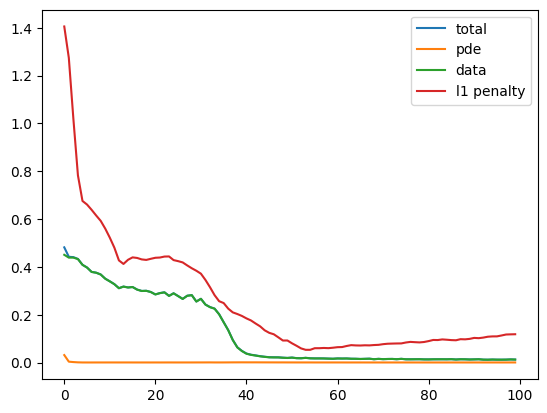

In [ ]:
plt.plot(pt.arange(0, 100), pt.tensor(lt).view(100, -1).mean(dim=1), label='total')
plt.plot(pt.arange(0, 100), pt.tensor(lp).view(100, -1).mean(dim=1), label='pde')
plt.plot(pt.arange(0, 100), pt.tensor(ld).view(100, -1).mean(dim=1), label='data')
plt.plot(pt.arange(0, 100), pt.tensor(ll).view(100, -1).mean(dim=1), label='l1 penalty')
plt.legend(loc='best')

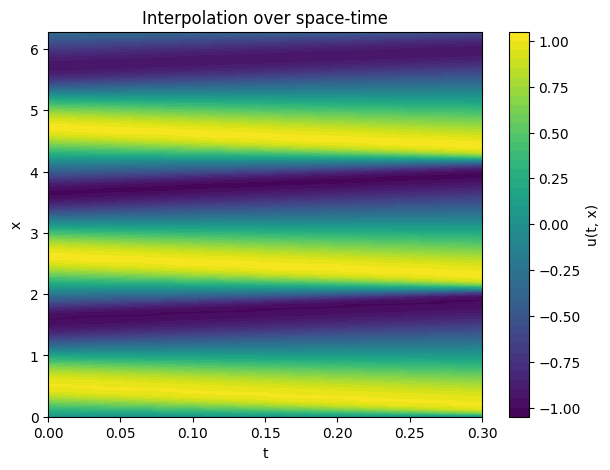

In [118]:
#=== Model Viewer (2D) ===#

# build grid (Pypt)
Nx, Nt = 100, 100
X = pt.linspace(x_lower, x_upper, Nx)
T = pt.linspace(t_lower, t_upper, Nt)

xv = X.repeat_interleave(Nt).view(-1, 1)   # shape (Nx*Nt, 1)
tv = T.repeat(Nx).view(-1, 1)              # shape (Nx*Nt, 1)
xt = pt.cat([xv, tv], dim=1)            # (Nx*Nt, 2)

net = model.net.eval()
with pt.no_grad():                      # no grads needed for plotting
    U = net(xt)                            # (Nx*Nt, 1)

# reshape back to (Nx, Nt)
U_grid = U.detach().cpu().view(Nx, Nt).numpy()
t_grid = tv.detach().cpu().view(Nx, Nt).numpy()
x_grid = xv.detach().cpu().view(Nx, Nt).numpy()

plt.figure(figsize=(7, 5))
plt.contourf(t_grid, x_grid, U_grid, levels=50, cmap='viridis')
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Interpolation over space-time')
plt.show()


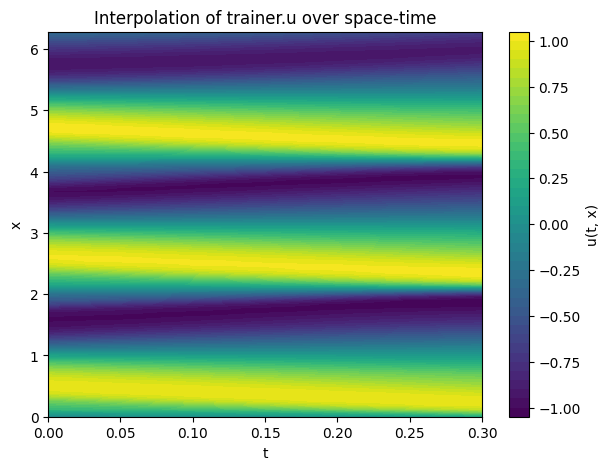

In [123]:
#=== u_model viewer ===#

t_vals = np.linspace(t_lower, t_upper, 100)
x_vals = np.linspace(x_lower, x_upper, 100)
T, X = np.meshgrid(t_vals, x_vals, indexing='ij')

# Flatten and convert to pt tensors
t_flat = pt.tensor(T.reshape(-1, 1), dtype=pt.float32)
x_flat = pt.tensor(X.reshape(-1, 1), dtype=pt.float32)

# Evaluate trainer.u over the grid (no grad needed)
# Use model.predict here
#u_pred = model.predict(xt)  # shape (batch_size, 1), float64
with pt.no_grad():
    U_pred = u_model1(t_flat, x_flat).cpu().numpy().reshape(T.shape)

# Plot
plt.figure(figsize=(7, 5))
plt.contourf(T, X, U_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(t, x)')
plt.xlabel('t') 
plt.ylabel('x')
plt.title('Interpolation of trainer.u over space-time')
plt.show()


In [ ]:
import torch as pt

def burgers_residual(u_model1, t_flat, x_flat, nu=None):
    """
    Computes residuals for inviscid or viscous Burgers on a flattened (t,x) grid.
    If nu is None -> inviscid: r = u_t + u*u_x
    If nu is float -> viscous: r = u_t + u*u_x - nu*u_xx
    """
    device = next(u_model1.parameters()).device
    t_flat = t_flat.to(device).detach().clone().requires_grad_(True)
    x_flat = x_flat.to(device).detach().clone().requires_grad_(True)

    # single forward pass
    u = u_model1(t_flat, x_flat)                  # (N,1)
    ones_u = pt.ones_like(u)

    # first derivatives
    du_dt = pt.autograd.grad(u, t_flat, grad_outputs=ones_u,
                             create_graph=True)[0]
    du_dx = pt.autograd.grad(u, x_flat, grad_outputs=ones_u,
                             create_graph=True)[0]

    # second derivative wrt x
    ones_dx = pt.ones_like(du_dx)
    d2u_dx2 = pt.autograd.grad(du_dx, x_flat, grad_outputs=ones_dx,
                               create_graph=True)[0]

    # residual
    r = du_dt + u * du_dx
    if nu is not None:
        r = r - nu * d2u_dx2

    # diagnostics
    with pt.no_grad():
        r_mean = r.abs().mean().item()
        r_max  = r.abs().max().item()
        ut_mean = du_dt.abs().mean().item()
        ux_mean = du_dx.abs().mean().item()
    return r, dict(res_mean=r_mean, res_max=r_max, ut_mean=ut_mean, ux_mean=ux_mean)

# usage
r, stats = burgers_residual(u_model1, t_flat, x_flat, nu=None)  # or nu=0.01/np.pi
print(stats)  # {'res_mean': ..., 'res_max': ..., 'ut_mean': ..., 'ux_mean': ...}


{'res_mean': 1.2736519575119019, 'res_max': 3.8166327476501465, 'ut_mean': 0.21662397682666779, 'ux_mean': 2.2943034172058105}


C:\Users\sami\AppData\Local\Temp\ipykernel_25452\997572076.py:68: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


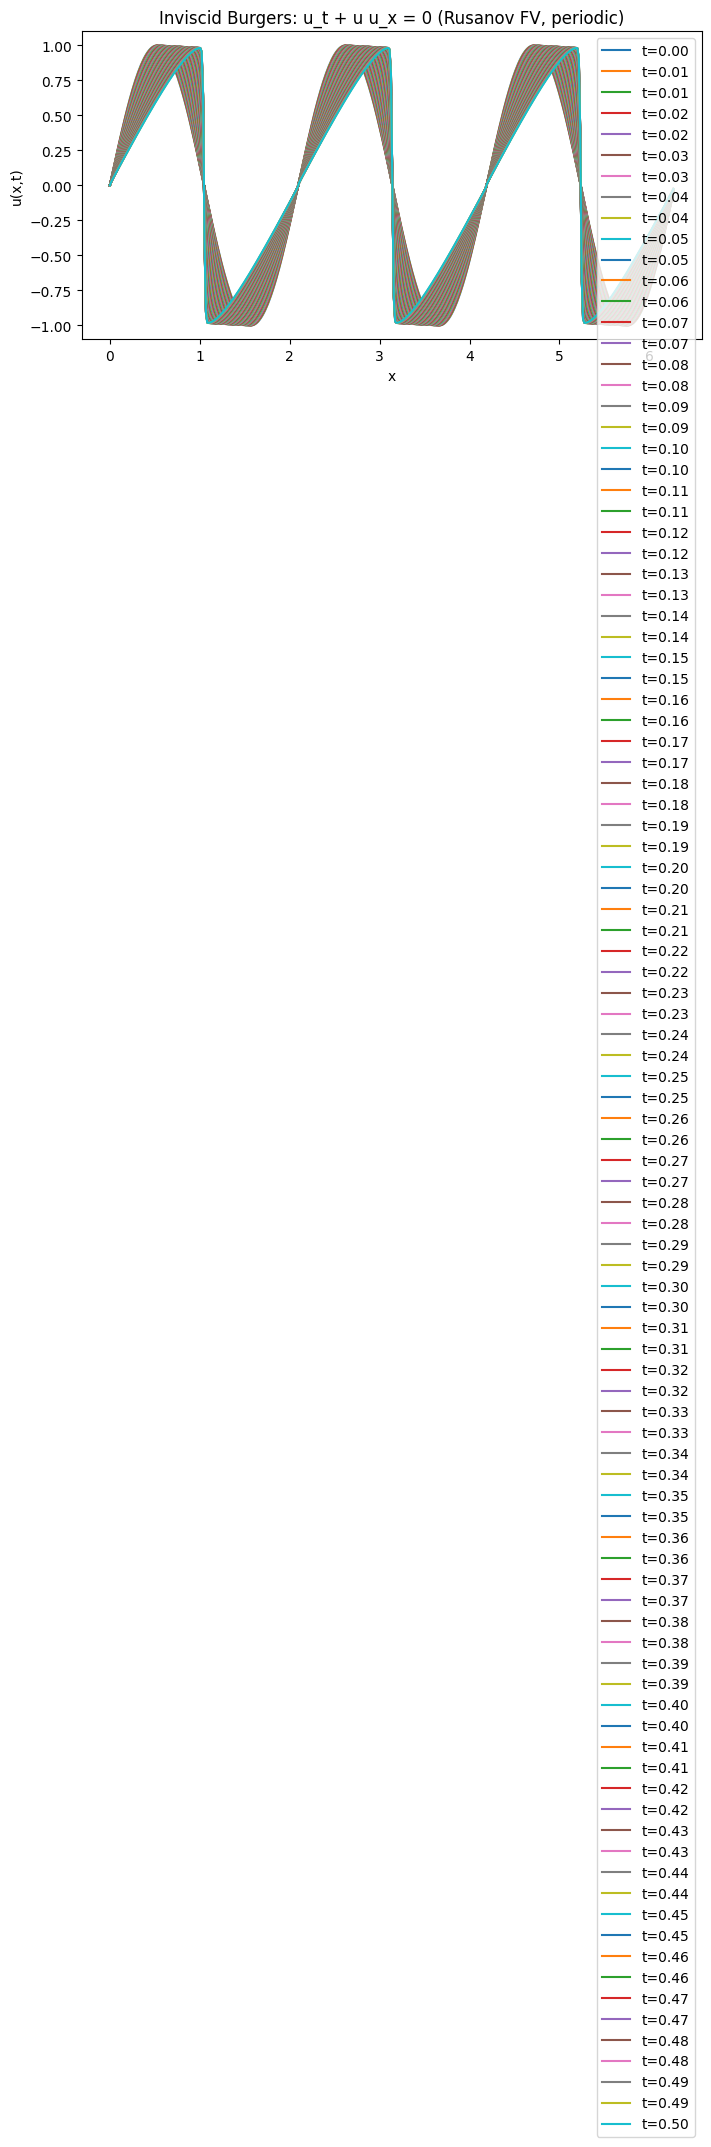

In [ ]:
#=== Burgers Data ===#

# Inviscid Burgers: u_t + (1/2 u^2)_x = 0  (equivalent to u_t + u u_x = 0)
# Finite-volume solver with Rusanov (local Lax-Friedrichs) flux on a periodic domain.
# Initial condition: u(x,0) = sin(3x), x in [0, 2π]
#
# We'll produce plots at a few times to show pre- and post-shock behavior.

# Domain and discretization
L = 2*np.pi
N = 400
x = np.linspace(0, L, N, endpoint=False)
dx = L / N

# Initial condition: sine wave of frequency 3
u0 = np.sin(3*x)

def flux(u):
    # f(u) = 1/2 u^2
    return 0.5 * u**2

def max_wave_speed(uL, uR):
    # For Burgers, |f'(u)| = |u|
    return np.maximum(np.abs(uL), np.abs(uR))

def rusanov_flux(uL, uR):
    # Local Lax-Friedrichs flux for scalar conservation law
    return 0.5*(flux(uL) + flux(uR)) - 0.5*max_wave_speed(uL, uR)*(uR - uL)

def step_rusanov(u, dt, dx):
    # Periodic extension via roll
    uL = u
    uR = np.roll(u, -1)
    F_iphalf = rusanov_flux(uL, uR)          # Flux at i+1/2
    F_imhalf = np.roll(F_iphalf, 1)          # Flux at i-1/2 (periodic)
    return u - (dt/dx) * (F_iphalf - F_imhalf)

def solve_burgers_rusanov(u0, T, cfl=0.5):
    u = u0.copy()
    t = 0.0
    # Time integration with adaptive dt from CFL
    while t < T:
        amax = np.max(np.abs(u))
        dt = cfl * dx / (amax + 1e-12)  # avoid zero division early
        if t + dt > T:
            dt = T - t
        u = step_rusanov(u, dt, dx)
        t += dt
    return u

# Times to snapshot
times = np.linspace(0,0.5,10).tolist()
solutions = []
for T in times:
    if T == 0.0:
        solutions.append(u0.copy())
    else:
        solutions.append(solve_burgers_rusanov(u0, T))

# Plot snapshots (all on one chart)
plt.figure(figsize=(8,4))
for T, u in zip(times, solutions):
    plt.plot(x, u, label=f"t={T:.2f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Inviscid Burgers: u_t + u u_x = 0 (Rusanov FV, periodic)")
plt.legend()
plt.tight_layout()
plt.show()

# Also provide a higher-resolution final-time snapshot saved to CSV for inspection
T_final = 0.5
u_final = solve_burgers_rusanov(u0, T_final)
data = np.column_stack([x, u_final])
csv_path = "../Data/burgers_sine_k3_T0p50.csv"
np.savetxt(csv_path, data, delimiter=",", header="x,u", comments="")


In [ ]:
#=== Collinearity Diagnostics ===#

# Robust collinearity diagnostics module + demo on a synthetic PDE feature matrix.
# This will generate plots and a CSV/JSON summary in /mnt/data and display a summary table.
#
# Notes:
# - Each chart is a separate matplotlib figure (no styles, no specified colors).
# - No external internet or sklearn usage; simple implementations are included where needed.
#
# Contents generated:
#   ../Data/pde_collinearity_summary.csv
#   ../Data/pde_collinearity_summary.json
#   ../Data/fig_corr_heatmap.png
#   ../Data/fig_cosine_heatmap.png
#   ../Data/fig_gram_spectrum.png
#   ../Data/fig_vif_barchart.png
#   ../Data/fig_mutual_coherence.png
#   ../Data/fig_qr_diag.png
#   ../Data/fig_ridge_paths.png
#   ../Data/fig_bootstrap_variance.png
#
# The synthetic feature matrix mimics common PDE libraries with intentional collinearity:
# {u, ux, uxx, u^2, u*ux, (u^2)_x, smoothed(ux), duplicated(uxx)+noise}.
#

# ------------------------------- Utils ----------------------------------
def zscore(F):
    mu = F.mean(axis=0, keepdims=True)
    std = F.std(axis=0, keepdims=True) + 1e-12
    return (F - mu)/std, mu.ravel(), std.ravel()

def pearson_corr(F):
    return np.corrcoef(F, rowvar=False)

def cosine_sim(F):
    # columns normalized
    norms = np.linalg.norm(F, axis=0, keepdims=True) + 1e-12
    Fn = F / norms
    return Fn.T @ Fn

def gram_spectrum(F):
    G = F.T @ F
    eigvals = np.linalg.eigvalsh(G)  # symmetric
    eigvals[::-1].sort()
    return eigvals

def vif_scores(Fz):
    # For each column j: regress f_j on F_{-j}, R^2, then VIF = 1/(1-R^2)
    n, p = Fz.shape
    vifs = []
    for j in range(p):
        idx = [k for k in range(p) if k != j]
        X = Fz[:, idx]
        y = Fz[:, j]
        # OLS
        beta, *_ = lstsq(X, y, rcond=None)
        yhat = X @ beta
        ssr = np.sum((yhat - y.mean())**2)
        sst = np.sum((y - y.mean())**2) + 1e-12
        R2 = ssr / sst
        vif = 1.0 / (1.0 - R2 + 1e-12)
        vifs.append(vif)
    return np.array(vifs)

def mutual_coherence(Fz):
    C = cosine_sim(Fz)
    # zero diagonal, take max absolute off-diag
    M = C - np.eye(C.shape[0])
    return np.max(np.abs(M)), C

def rrqr(Fz):
    # Rank-revealing QR with column pivoting
    Q, R, piv = la.qr(Fz, mode='economic', pivoting=True)
    diagR = np.abs(np.diag(R))
    return diagR, piv

def principal_angle_between(A, B):
    # Compute smallest principal angle between the column spaces of A and B
    # Using orthonormal bases via QR
    Qa, _ = la.qr(A, mode='economic')
    Qb, _ = la.qr(B, mode='economic')
    S = svd(Qa.T @ Qb, compute_uv=False)
    # clamp due to numeric
    s = np.clip(S, 0, 1)
    # Largest singular value corresponds to smallest angle cos(theta_max)
    cos_theta = s[0]
    theta = np.arccos(cos_theta)
    return theta

def ridge_path(Fz, y, lambdas):
    # Closed-form ridge path
    FtF = Fz.T @ Fz
    Fty = Fz.T @ y
    coefs = []
    for lam in lambdas:
        A = FtF + lam * np.eye(Fz.shape[1])
        c = la.solve(A, Fty)
        coefs.append(c)
    return np.array(coefs)

def bootstrap_coeff_var(Fz, y, lam_ridge=1e-2, n_boot=200, frac=0.7, rng=None):
    if rng is None: rng = np.random.default_rng(0)
    n = Fz.shape[0]
    coefs = []
    FtF = Fz.T @ Fz
    I = np.eye(Fz.shape[1])
    for _ in range(n_boot):
        idx = rng.choice(n, size=int(frac*n), replace=True)
        Fb = Fz[idx]
        yb = y[idx]
        c = la.solve(Fb.T @ Fb + lam_ridge*I, Fb.T @ yb)
        coefs.append(c)
    C = np.array(coefs)
    return C.var(axis=0), C

# -------------------------- Synthetic Feature Matrix ---------------------
def make_synthetic_PDE_features(n=1000, L=2*np.pi, seed=0):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, L, n, endpoint=False)
    # Build u as a mixture of sinusoids
    u = (np.sin(2*pi*x/L*1.0) +
         0.7*np.sin(2*pi*x/L*2.0 + 0.3) +
         0.3*np.sin(2*pi*x/L*3.0 + 1.2))
    # smooth u slight
    u = u + 0.05*rng.normal(0,1,n)

    # numerical derivatives (spectral for periodic)
    k = np.fft.fftfreq(n, d=L/n) * 2*np.pi  # angular wavenumbers
    U = np.fft.fft(u)
    ux = np.fft.ifft(1j*k*U).real
    uxx = np.fft.ifft(-k**2*U).real

    # Construct common library terms
    u2 = u**2
    uux = u*ux
    u2x = np.fft.ifft(1j*k*np.fft.fft(u**2)).real  # (u^2)_x
    ux_smooth = scipy.signal.convolve(ux, np.ones(11)/11.0, mode='same')  # smoothed ux (near collinear with ux)
    uxx_dup = uxx + 0.01*rng.normal(0,1,n)                       # duplicate uxx + tiny noise

    F = np.column_stack([u, ux, uxx, u2, uux, u2x, ux_smooth, uxx_dup])
    names = ["u","ux","uxx","u2","u*ux","(u2)_x","ux_smooth","uxx_dup"]
    return x, F, names

def make_PDE_features_from_dde(
    model,
    n=1024,
    x_bounds=(-1.0, 1.0),
    t0=0.25,
    periodic=False,
    smooth_window=11,
    noise_std_dup=0.01,
    seed=0,
):
    """
    Build a PDE feature matrix F from a DeepXDE model snapshot u(x, t0).

    Args
    ----
    model : dde.Model          # already compiled/trained
    n : int                    # number of x samples
    x_bounds : (float, float)  # domain [xmin, xmax]
    t0 : float                 # time slice to sample
    periodic : bool            # True → spectral derivs; False → finite differences
    smooth_window : int        # length of moving-average kernel for ux_smooth
    noise_std_dup : float      # noise std for uxx_dup (near-duplicate)
    seed : int                 # RNG seed for the duplicate noise

    Returns
    -------
    x : (n,) array
    F : (n, p) array           # columns: [u, ux, uxx, u^2, u*ux, (u^2)_x, ux_smooth, uxx_dup]
    names : list[str]
    """
    rng = np.random.default_rng(seed)

    # --- sample grid & query DeepXDE model ---
    xmin, xmax = x_bounds
    x = np.linspace(xmin, xmax, n, endpoint=False)
    t = np.full_like(x, fill_value=t0)

    # DeepXDE expects input as [x, t] columns
    xt = np.stack([x, t], axis=1)
    u = np.asarray(model.predict(xt), dtype=float).reshape(-1)

    # --- derivatives ---
    if periodic:
        # spectral derivatives on periodic domain
        L = xmax - xmin
        k = np.fft.fftfreq(n, d=L/n) * 2*np.pi  # angular wavenumbers
        U = np.fft.fft(u)
        ux  = np.fft.ifft(1j * k * U).real
        uxx = np.fft.ifft(-(k**2) * U).real
        u2x = np.fft.ifft(1j * k * np.fft.fft(u**2)).real
    else:
        # finite-difference derivatives on uniform grid
        # np.gradient handles the spacing correctly
        dx = (xmax - xmin) / n
        ux  = np.gradient(u, dx, edge_order=2)
        uxx = np.gradient(ux, dx, edge_order=2)
        u2x = np.gradient(u**2, dx, edge_order=2)

    # --- library terms ---
    u2        = u**2
    uux       = u * ux
    # simple moving-average smoothing (no scipy)
    kernel    = np.ones(int(smooth_window), dtype=float) / float(smooth_window)
    ux_smooth = np.convolve(ux, kernel, mode="same")
    uxx_dup   = uxx + noise_std_dup * rng.normal(0.0, 1.0, size=n)

    F = np.column_stack([u, ux, uxx, u2, uux, u2x, ux_smooth, uxx_dup])
    names = ["u", "ux", "uxx", "u2", "u*ux", "(u2)_x", "ux_smooth", "uxx_dup"]
    return x, F, names

#x, F, names = make_synthetic_PDE_features(n=1200, L=2*np.pi, seed=4)
x, F, names = make_PDE_features_from_dde(
    model,
    n=1200,
    x_bounds=(-1, 1),
    t0=0.25,          # pick any time slice you want
    periodic=False,   # your DeepXDE setup is non-periodic on [-1,1]
    smooth_window=11
)


# Simulate a target ut as a linear combo with noise (e.g., Burgers-like: ut = -u*ux + 0.1 uxx)
true_c = np.array([0.0, 0.0, 0.1, 0.0, -1.0, 0.0, 0.0, 0.0])
rng = np.random.default_rng(42)
ut = F @ true_c + 0.01 * rng.normal(0,1,F.shape[0])

# Z-score features
Fz, mu, std = zscore(F)

# ------------------------------- Metrics ---------------------------------
C_pearson = pearson_corr(Fz)
C_cosine = cosine_sim(Fz)
eigvals = gram_spectrum(Fz)
kappa = cond(Fz)
vifs = vif_scores(Fz)
mu_coh, C_cos = mutual_coherence(Fz)
diagR, piv = rrqr(Fz)

# Principal angle example: between span{ux, ux_smooth} and span{uxx, uxx_dup}
idxA = [names.index("ux"), names.index("ux_smooth")]
idxB = [names.index("uxx"), names.index("uxx_dup")]
theta_AB = principal_angle_between(Fz[:, idxA], Fz[:, idxB])
theta_deg = float(theta_AB * 180.0/np.pi)

# Ridge path
lambdas = np.logspace(-4, 2, 60)
coefs_path = ridge_path(Fz, ut, lambdas)

# Bootstrap variance under ridge
coef_var, coef_samples = bootstrap_coeff_var(Fz, ut, lam_ridge=1e-2, n_boot=300, frac=0.6, rng=rng)

# ------------------------------- Plots -----------------------------------
# 1) Pearson correlation heatmap
fig = plt.figure(figsize=(6,5.5))
plt.imshow(C_pearson, vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.yticks(range(len(names)), names)
plt.title("Feature correlation (z-scored columns)")
fig.tight_layout()
path_corr = "../Data/fig_corr_heatmap.png"
fig.savefig(path_corr, dpi=160)
plt.close(fig)

# 2) Cosine similarity heatmap
fig = plt.figure(figsize=(6,5.5))
plt.imshow(C_cosine, vmin=0, vmax=1)
plt.colorbar(label="Cosine similarity")
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.yticks(range(len(names)), names)
plt.title("Feature cosine similarity (column-normalized)")
fig.tight_layout()
path_cos = "../Data/fig_cosine_heatmap.png"
fig.savefig(path_cos, dpi=160)
plt.close(fig)

# 3) Gram spectrum (eigenvalues)
fig = plt.figure(figsize=(6.5,4.2))
plt.semilogy(range(1, len(eigvals)+1), eigvals, marker='o')
plt.xlabel("Index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Gram spectrum: rapid decay indicates near-dependence")
plt.grid(True, linewidth=0.3)
fig.tight_layout()
path_spectrum = "../Data/fig_gram_spectrum.png"
fig.savefig(path_spectrum, dpi=160)
plt.close(fig)

# 4) VIF bar chart
fig = plt.figure(figsize=(7,4.2))
plt.bar(range(len(names)), vifs)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylabel("VIF")
plt.title("Variance Inflation Factor per feature")
plt.grid(True, axis='y', linewidth=0.3)
fig.tight_layout()
path_vif = "../Data/fig_vif_barchart.png"
fig.savefig(path_vif, dpi=160)
plt.close(fig)

# 5) Mutual coherence as a single number + bar of top pairs
# Compute top 10 absolute cosine similarities off-diagonal
abs_cos = np.abs(C_cosine - np.eye(len(names)))
pairs = []
for i in range(len(names)):
    for j in range(i+1, len(names)):
        pairs.append((abs_cos[i,j], i, j))
pairs.sort(reverse=True)
top_pairs = pairs[:10]
fig = plt.figure(figsize=(7,4.2))
vals = [p[0] for p in top_pairs]
labels = [f"{names[p[1]]} vs {names[p[2]]}" for p in top_pairs]
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), labels, rotation=45, ha='right')
plt.ylim(0,1.0)
plt.ylabel("|cosine|")
plt.title("Top-10 most collinear feature pairs (by cosine)")
plt.grid(True, axis='y', linewidth=0.3)
fig.tight_layout()
path_mu = "../Data/fig_mutual_coherence.png"
fig.savefig(path_mu, dpi=160)
plt.close(fig)

# 6) RRQR diagnostics (R diagonals)
fig = plt.figure(figsize=(7,4.2))
plt.plot(diagR, marker='o')
plt.xlabel("Rank index (pivot order)")
plt.ylabel("|R_ii|")
plt.title("RRQR: small |R_ii| reveals redundant/weak columns")
plt.grid(True, linewidth=0.3)
fig.tight_layout()
path_qr = "../Data/fig_qr_diag.png"
fig.savefig(path_qr, dpi=160)
plt.close(fig)

# 7) Ridge coefficient paths
fig = plt.figure(figsize=(7,4.2))
for j in range(len(names)):
    plt.plot(lambdas, coefs_path[:,j], label=names[j])
plt.xscale('log')
plt.xlabel("Ridge λ")
plt.ylabel("Coefficient")
plt.title("Ridge coefficient paths (strong-form features)")
plt.grid(True, linewidth=0.3)
plt.legend(fontsize=8, ncol=2, frameon=False)
fig.tight_layout()
path_ridge = "../Data/fig_ridge_paths.png"
fig.savefig(path_ridge, dpi=160)
plt.close(fig)

# 8) Bootstrap coefficient variance (bar)
fig = plt.figure(figsize=(7,4.2))
plt.bar(range(len(names)), coef_var)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylabel("Var[coef] (bootstrap, ridge λ=1e-2)")
plt.title("Estimation instability under resampling (collinearity → high variance)")
plt.grid(True, axis='y', linewidth=0.3)
fig.tight_layout()
path_boot = "../Data/fig_bootstrap_variance.png"
fig.savefig(path_boot, dpi=160)
plt.close(fig)

# ---------------------------- Tabular Summary ----------------------------
summary = {
    "n_samples": int(F.shape[0]),
    "n_features": int(F.shape[1]),
    "condition_number(Fz)": float(kappa),
    "mutual_coherence": float(mu_coh),
    "min_RRQR_diag": float(diagR.min()),
    "principal_angle_deg(span{ux,ux_smooth} vs span{uxx,uxx_dup})": float(theta_deg),
    "max_pairwise_corr": float(np.max(np.abs(C_pearson - np.eye(len(names))))),
    "mean_VIF": float(np.mean(vifs)),
    "max_VIF": float(np.max(vifs)),
}

# prepare a per-feature table
df = pd.DataFrame({
    "feature": names,
    "VIF": vifs,
    "mean_abs_corr": np.mean(np.abs(C_pearson - np.eye(len(names))), axis=0),
    "bootstrap_var_ridge": coef_var
})

# save files
csv_path = "../Data/pde_collinearity_summary.csv"
json_path = "../Data/pde_collinearity_summary.json"
df.to_csv(csv_path, index=False)
with open(json_path, "w") as f:
    json.dump({"summary": summary, "feature_table_path": csv_path}, f, indent=2)

# Display dataframe
df.to_csv("pde_collinearity_summary.csv", index=False)
print(df.head())  # quick peek

# Return paths to key artifacts
print('\nSaved Data Paths:')
{
 "csv": csv_path,
 "json": json_path,
 "figures": [path_corr, path_cos, path_spectrum, path_vif, path_mu, path_qr, path_ridge, path_boot]
}



  feature           VIF  mean_abs_corr  bootstrap_var_ridge
0       u  8.645485e+00       0.307052             0.002921
1      ux  7.313072e+03       0.227898            13.242449
2     uxx  3.580217e+06       0.426546             0.165747
3      u2  6.999641e+00       0.209392             0.002767
4    u*ux  2.017070e+09       0.423614             0.001080

Saved Data Paths:


{'csv': '../Data/pde_collinearity_summary.csv',
 'json': '../Data/pde_collinearity_summary.json',
 'figures': ['../Data/fig_corr_heatmap.png',
  '../Data/fig_cosine_heatmap.png',
  '../Data/fig_gram_spectrum.png',
  '../Data/fig_vif_barchart.png',
  '../Data/fig_mutual_coherence.png',
  '../Data/fig_qr_diag.png',
  '../Data/fig_ridge_paths.png',
  '../Data/fig_bootstrap_variance.png']}

In [ ]:
# Burgers' equation (inviscid) finite-volume Rusanov solver with MUSCL (minmod) + SSPRK(3,3)
# Periodic domain [0, 2π], pre-shock final time T=0.07 (smooth regime)
# Saves float32 arrays and provides a batch sampler. Also makes quicklook plots.

import numpy as np
import matplotlib.pyplot as plt
from math import pi

def minmod(a, b):
    """Elementwise minmod slope limiter."""
    s = np.sign(a) * np.sign(b)
    return 0.5 * (1 + s) * np.minimum(np.abs(a), np.abs(b)) * np.sign(a)

def rusanov_flux(uL, uR):
    """Rusanov (Lax–Friedrichs) flux for inviscid Burgers: f(u) = 0.5 u^2."""
    fL = 0.5 * uL**2
    fR = 0.5 * uR**2
    a = np.maximum(np.abs(uL), np.abs(uR))  # max wavespeed |u|
    return 0.5 * (fL + fR) - 0.5 * a * (uR - uL)

def muscl_reconstruct(u, theta=1.0):
    """
    MUSCL piecewise-linear reconstruction with minmod limiter.
    Returns left/right interface states (u_{j+1/2}^-, u_{j+1/2}^+).
    Periodic boundary conditions via roll.
    theta in [1,2] is a common bias parameter; theta=1 is standard.
    """
    um = np.roll(u, 1)   # u_{j-1}
    up = np.roll(u, -1)  # u_{j+1}

    # Raw slopes
    dl = u - um   # Δ_- = u_j - u_{j-1}
    dr = up - u   # Δ_+ = u_{j+1} - u_j

    # Limited slope (minmod of theta*dl and dr, symmetric form)
    sigma = minmod(theta * dl, 0.5 * (up - um))
    sigma = minmod(sigma, theta * dr)

    # Left/right states at interfaces j+1/2 and j-1/2
    uL_iphalf = u + 0.5 * sigma
    uR_iphalf = np.roll(u, -1) - 0.5 * np.roll(sigma, -1)  # right state from cell j+1

    return uL_iphalf, uR_iphalf

def fv_rhs(u, dx):
    """Finite-volume spatial operator L(u) with Rusanov flux and MUSCL reconstruction (periodic)."""
    uL, uR = muscl_reconstruct(u, theta=1.0)
    # Interface fluxes at i+1/2
    F_iphalf = rusanov_flux(uL, uR)
    # Divergence: (F_{i-1/2} - F_{i+1/2}) / dx  (note periodic via roll)
    return (np.roll(F_iphalf, 1) - F_iphalf) / dx

def ssprk3_step(u, dt, dx):
    """One SSPRK(3,3) step using rhs L(u)."""
    k1 = fv_rhs(u, dx)
    u1 = u + dt * k1

    k2 = fv_rhs(u1, dx)
    u2 = 0.75 * u + 0.25 * (u1 + dt * k2)

    k3 = fv_rhs(u2, dx)
    u3 = (1.0/3.0) * u + (2.0/3.0) * (u2 + dt * k3)

    return u3

def initial_condition(x, kind="sin36"):
    if kind == "sin3":
        return np.sin(3.0 * x)
    elif kind == "sin36":
        return np.sin(3.0 * x) + 0.5 * np.sin(6.0 * x)
    else:
        raise ValueError("Unknown IC kind: " + str(kind))

def diagnostics(x, u):
    dx = x[1] - x[0]
    mass = np.sum(u) * dx
    energy = 0.5 * np.sum(u**2) * dx
    tv = np.sum(np.abs(np.roll(u, -1) - u))
    umax = np.max(np.abs(u))
    return mass, energy, tv, umax

def simulate_burgers(
    N=256, T=0.2, CFL=0.45, snaps=101, ic_kind="sin36", dtype=np.float32, seed=0
):
    rng = np.random.default_rng(seed)

    # Grid
    L = 2.0 * np.pi
    x = np.linspace(0.0, L, N, endpoint=False).astype(dtype)
    dx = (L) / N

    # Initial condition
    u = initial_condition(x.astype(np.float64), kind=ic_kind).astype(dtype)

    # Save structure
    t_save = np.linspace(0.0, T, snaps, dtype=dtype)
    Nt = len(t_save)
    U = np.zeros((Nt, N), dtype=dtype)
    M = np.zeros(Nt, dtype=dtype)
    E = np.zeros(Nt, dtype=dtype)
    TV = np.zeros(Nt, dtype=dtype)
    Umax = np.zeros(Nt, dtype=dtype)

    # Record t=0
    U[0] = u
    m, e, tv, umax = diagnostics(x.astype(np.float64), u.astype(np.float64))
    M[0], E[0], TV[0], Umax[0] = [dtype(m), dtype(e), dtype(tv), dtype(umax)]

    t = 0.0
    save_idx = 1
    eps = 1e-12

    while save_idx < Nt:
        # Adaptive dt via CFL; guard against zero max speed
        amax = float(np.max(np.abs(u)))
        if amax < 1e-12:
            dt = (t_save[save_idx] - t)  # jump to next save
        else:
            dt_cfl = CFL * dx / (amax + eps)
            dt = min(dt_cfl, float(t_save[save_idx] - t))

        # Advance
        u = ssprk3_step(u, dt, dx)
        t += dt

        # If we hit the save time (within tolerance), record
        if t >= t_save[save_idx] - 1e-12:
            U[save_idx] = u
            m, e, tv, umax = diagnostics(x.astype(np.float64), u.astype(np.float64))
            M[save_idx], E[save_idx], TV[save_idx], Umax[save_idx] = [
                dtype(m),
                dtype(e),
                dtype(tv),
                dtype(umax),
            ]
            save_idx += 1

    return x, t_save, U, {"mass": M, "energy": E, "tv": TV, "umax": Umax}

def save_npz(path, x, t, U, diag):
    np.savez(
        path,
        x=x,
        t=t,
        U=U,
        mass=diag["mass"],
        energy=diag["energy"],
        tv=diag["tv"],
        umax=diag["umax"],
    )

def sampler_from_npz(npz_path, batch_size=1024, noise_std=0.0, seed=0):
    """Returns a callable that samples (t, x, u) triplets uniformly from stored grid (with optional Gaussian noise)."""
    data = np.load(npz_path)
    x = data["x"]
    t = data["t"]
    U = data["U"]
    rng = np.random.default_rng(seed)

    #def sample(batch_size=batch_size, noise_std=noise_std):
    #    ti = rng.integers(0, len(t), size=batch_size)
    #    xi = rng.integers(0, len(x), size=batch_size)
    #    tb = t[ti]
    #    xb = x[xi]
    #    ub = U[ti, xi].copy()
    #    if noise_std > 0:
    #        ub = ub + rng.normal(0.0, noise_std, size=ub.shape).astype(ub.dtype)
    #    return tb.astype(np.float32), xb.astype(np.float32), ub.astype(np.float32)

    T, X = np.meshgrid(t, x, indexing='ij')
    Tb = T.reshape(-1,1)
    Xb = X.reshape(-1,1)
    Ub = U.reshape(-1,1)
    if noise_std > 0:
        Ub = Ub + rng.normal(0.0, noise_std, size=Ub.shape).astype(Ub.dtype)
    return (pt.tensor(Tb, dtype=pt.float32),
            pt.tensor(Xb, dtype=pt.float32),
            pt.tensor(Ub, dtype=pt.float32))

def quick_plots(save_prefix, x, t, U, diag):
    # Space-time heatmap
    plt.figure(figsize=(7,4))
    plt.imshow(U, aspect='auto', origin='lower', extent=[x[0], x[-1]+(x[1]-x[0]), float(t[0]), float(t[-1])])
    plt.colorbar(label='u')
    plt.xlabel('x'); plt.ylabel('t'); plt.title('u(t,x)')
    plt.tight_layout()
    heatmap_path = f"{save_prefix}_heatmap.png"
    plt.savefig(heatmap_path, dpi=160)
    plt.close()

    # Time slices
    ts_show = [0, int(len(t)*0.33), int(len(t)*0.66), len(t)-1]
    plt.figure(figsize=(7,4))
    for idx in ts_show:
        plt.plot(x, U[idx], label=f"t={float(t[idx]):.3f}")
    plt.legend()
    plt.xlabel('x'); plt.ylabel('u'); plt.title('Time slices')
    plt.tight_layout()
    lines_path = f"{save_prefix}_timeslices.png"
    plt.savefig(lines_path, dpi=160)
    plt.close()

    # Diagnostics
    fig, axes = plt.subplots(2,2, figsize=(9,6))
    axes = axes.ravel()
    axes[0].plot(t, diag["mass"]); axes[0].set_title("Mass"); axes[0].set_xlabel("t")
    axes[1].plot(t, diag["energy"]); axes[1].set_title("Energy"); axes[1].set_xlabel("t")
    axes[2].plot(t, diag["tv"]); axes[2].set_title("Total Variation"); axes[2].set_xlabel("t")
    axes[3].plot(t, diag["umax"]); axes[3].set_title("max |u|"); axes[3].set_xlabel("t")
    fig.tight_layout()
    diag_path = f"{save_prefix}_diagnostics.png"
    plt.savefig(diag_path, dpi=160)
    plt.close()
    return heatmap_path, lines_path, diag_path

# --- Run a default simulation and save outputs ---
x, t, U, diag = simulate_burgers(N=256, T=0.3, CFL=0.45, snaps=1000, ic_kind="sin36", dtype=np.float32, seed=0)
npz_path = "../Data/burgers_inv/burgers_inviscid_pre_shock_N256_T0p07.npz"
save_npz(npz_path, x, t, U, diag)
heatmap_path, lines_path, diag_path = quick_plots("../Data/burgers_inv/burgers_inviscid_pre_shock_N256_T0p07", x, t, U, diag)

(npz_path, heatmap_path, lines_path, diag_path)


('../Data/burgers_inv/burgers_inviscid_pre_shock_N256_T0p07.npz',
 '../Data/burgers_inv/burgers_inviscid_pre_shock_N256_T0p07_heatmap.png',
 '../Data/burgers_inv/burgers_inviscid_pre_shock_N256_T0p07_timeslices.png',
 '../Data/burgers_inv/burgers_inviscid_pre_shock_N256_T0p07_diagnostics.png')